In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import pymc.sampling_jax
import scipy.stats as stats
import seaborn as sns
import arviz as az
import xarray as xr
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 1234
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
def generate():
    group_list = ["one", "two", "three", "four", "five"]
    trials_per_group = 20
    group_intercepts = rng.normal(0, 1, len(group_list))
    group_slopes = np.ones(len(group_list)) * -0.5
    group_mx = group_intercepts * 2
    group = np.repeat(group_list, trials_per_group)
    subject = np.concatenate(
        [np.ones(trials_per_group) * i for i in np.arange(len(group_list))]
    ).astype(int)
    intercept = np.repeat(group_intercepts, trials_per_group)
    slope = np.repeat(group_slopes, trials_per_group)
    mx = np.repeat(group_mx, trials_per_group)
    x = rng.normal(mx, 1)
    y = rng.normal(intercept + (x - mx) * slope, 1)
    data = pd.DataFrame({"group": group, "group_idx": subject, "x": x, "y": y})
    return data, group_list

In [4]:
data, group_list = generate()

In [5]:
print(group_list)

['one', 'two', 'three', 'four', 'five']


In [6]:
display(data)

,group,group_idx,x,y
0,one,0,-0.294574,-2.338519
1,one,0,-4.686497,-1.448057
2,one,0,-2.262201,-1.393728
3,one,0,-4.873809,-0.265403
4,one,0,-2.863929,-0.774251
...,...,...,...,...
95,five,4,3.981413,0.467970
96,five,4,1.889102,0.553290
97,five,4,2.561267,2.590966
98,five,4,0.147378,2.050944


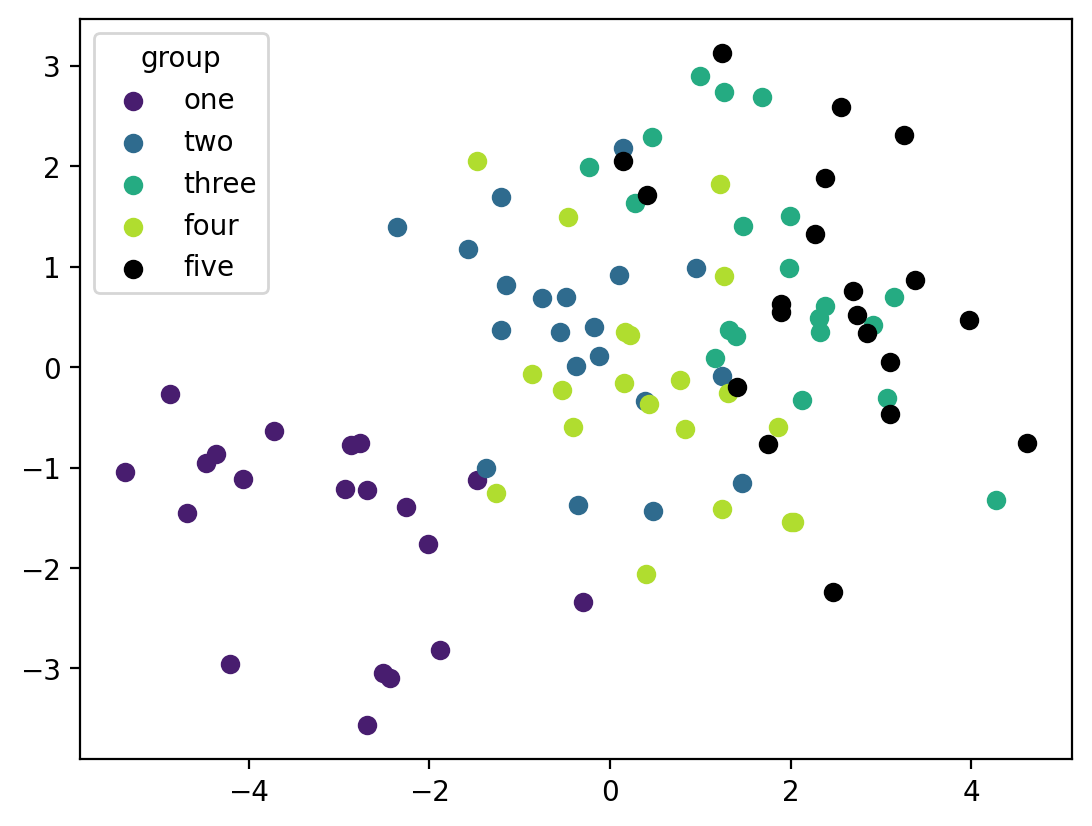

In [7]:
for i, group in enumerate(group_list):
    plt.scatter(
        data.x[data.group_idx == i],
        data.y[data.group_idx == i],
        color=f"C{i}",
        label=f"{group}",
    )
plt.legend(title="group");

In [8]:
with pm.Model() as linear_regression:
    sigma = pm.HalfCauchy("sigma", beta=2)
    β0 = pm.Normal("β0", 0, sigma=5)
    β1 = pm.Normal("β1", 0, sigma=5)
    x = pm.MutableData("x", data.x, dims="obs_id")
    μ = pm.Deterministic("μ", β0 + β1 * x, dims="obs_id")
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")

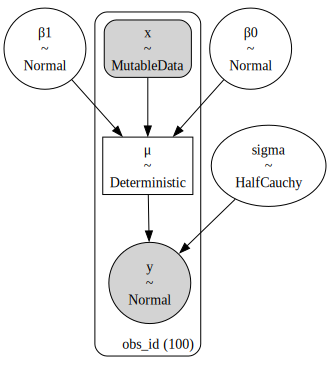

In [9]:
pm.model_to_graphviz(linear_regression)

In [10]:
with linear_regression:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time =  0:00:00.886826
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.664021
Transforming variables...
Transformation time =  0:00:00.080197


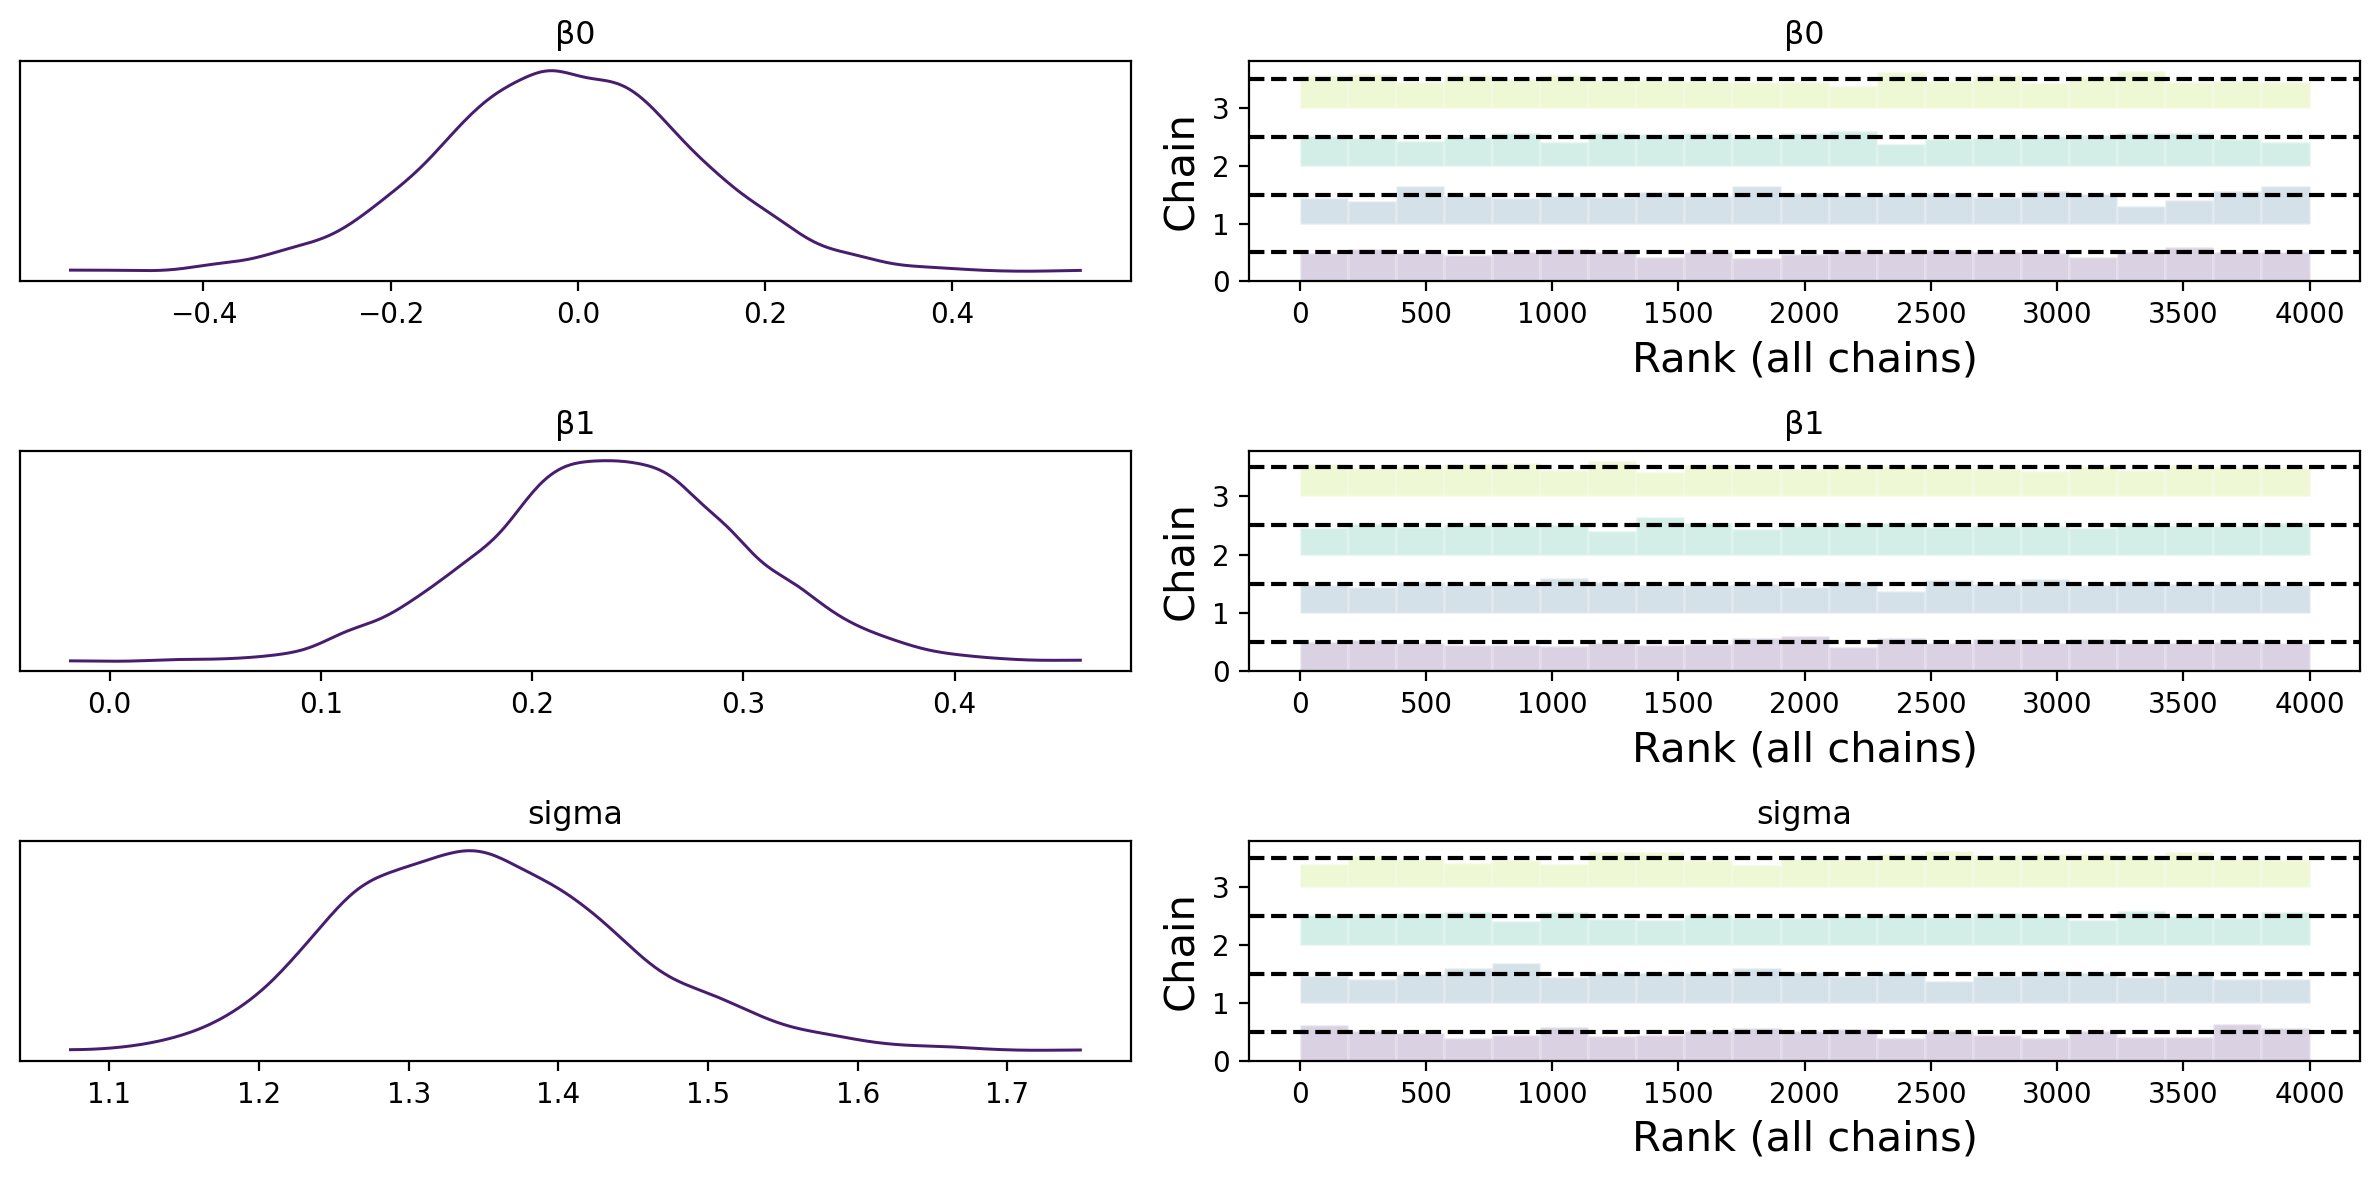

In [11]:
az.plot_trace(
    idata,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    combined=True,
    divergences="bottom",
)
plt.tight_layout()

In [12]:
# posterior prediction for these x values
xi = np.linspace(data.x.min(), data.x.max(), 20)

# do posterior predictive inference
with linear_regression:
    pm.set_data({"x": xi})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["y", "μ"]))

Sampling: [y]


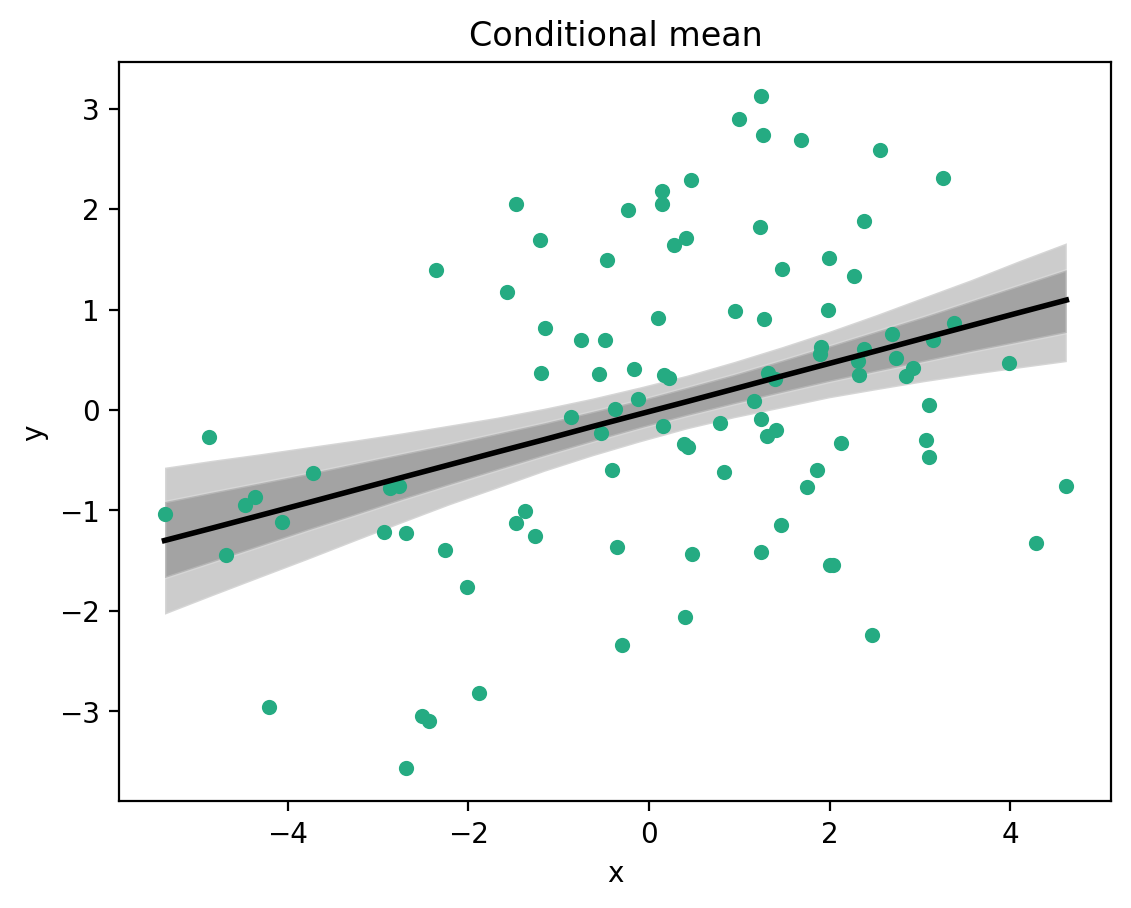

In [13]:
post = az.extract(idata)

xi = xr.DataArray(np.linspace(np.min(data['x']), np.max(data['x']), 20), dims=["x_plot"])
y = post.β0 + post.β1 * xi
region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")

fig, ax = plt.subplots(1, 1)

ax.fill_between(
    xi, region.sel(quantile=0.025), region.sel(quantile=0.975), alpha=0.2, color="k", edgecolor="w"
)
ax.fill_between(
    xi, region.sel(quantile=0.15), region.sel(quantile=0.85), alpha=0.2, color="k", edgecolor="w"
)

# Plotting the conditional mean
ax.plot(xi, region.sel(quantile=0.5), "k", linewidth=2)

# Plotting the data points
ax.scatter(data['x'], data['y'], color='C2', s=20, label='Data points')

# Formatting
ax.set(xlabel="x", ylabel="y", title="Conditional mean")

plt.show()  # Add this line to actually show the plot

In [14]:
beta_0 = idata.posterior.β0.mean().values
print(beta_0)

-0.015561122624353059


In [15]:
beta_1 = idata.posterior.β1.mean().values
print(beta_1)

0.2383484530430293


In [16]:
xi = np.linspace(np.min(data["x"]), np.max(data["x"]), 20)
xi

array([-5.36681262, -4.84109642, -4.31538022, -3.78966402, -3.26394782,
       -2.73823162, -2.21251541, -1.68679921, -1.16108301, -0.63536681,
       -0.10965061,  0.41606559,  0.94178179,  1.46749799,  1.9932142 ,
        2.5189304 ,  3.0446466 ,  3.5703628 ,  4.096079  ,  4.6217952 ])

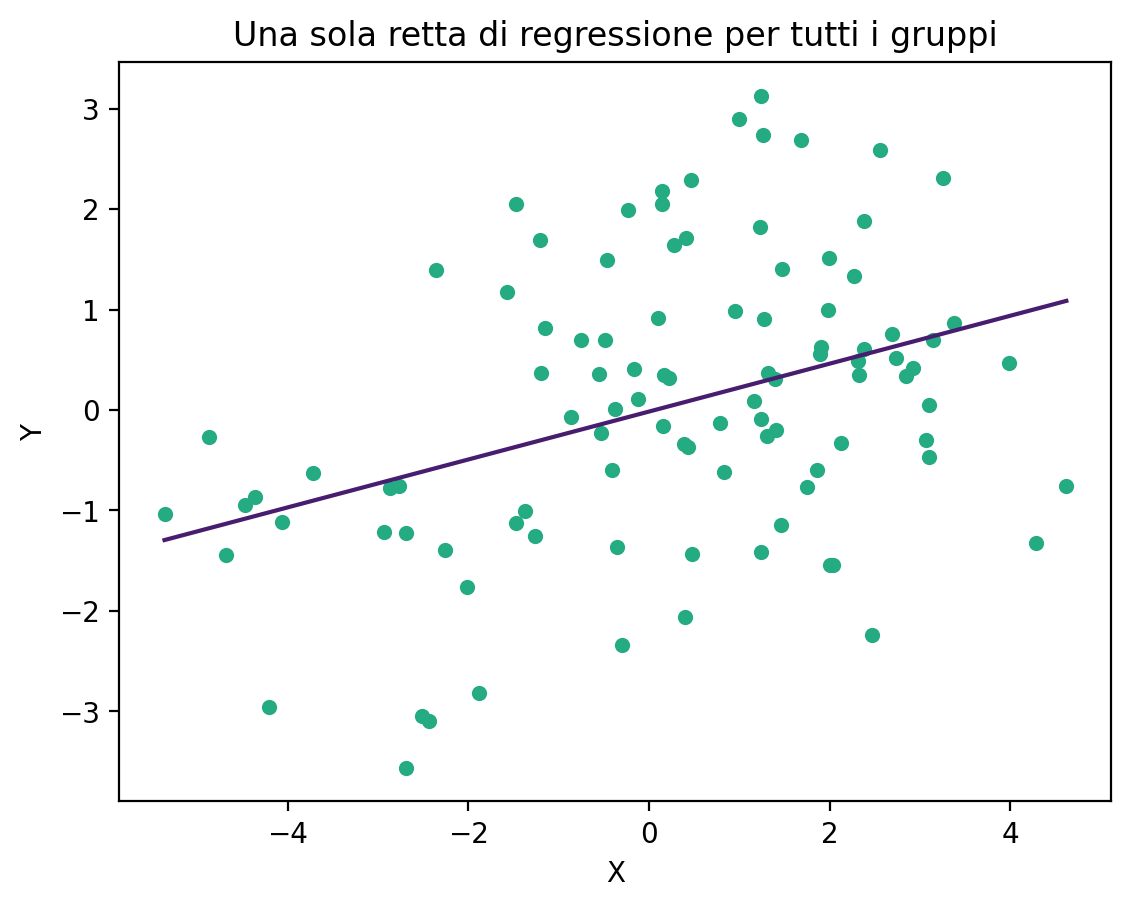

In [17]:
# Genera la linea di regressione utilizzando l'equazione della retta
y_pred = beta_0 + beta_1 * xi

# Visualizza la linea di regressione
plt.plot(xi, y_pred)
plt.scatter(data['x'], data['y'], color='C2', s=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Una sola retta di regressione per tutti i gruppi')
plt.show()

In [18]:
az.summary(idata, var_names="β1")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β1,0.238,0.062,0.119,0.354,0.001,0.001,3648.0,3121.0,1.0


In [19]:
coords = {"group": group_list}

with pm.Model(coords=coords) as ind_slope_intercept:
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=2, dims="group")
    β0 = pm.Normal("β0", 0, sigma=5, dims="group")
    β1 = pm.Normal("β1", 0, sigma=5, dims="group")
    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

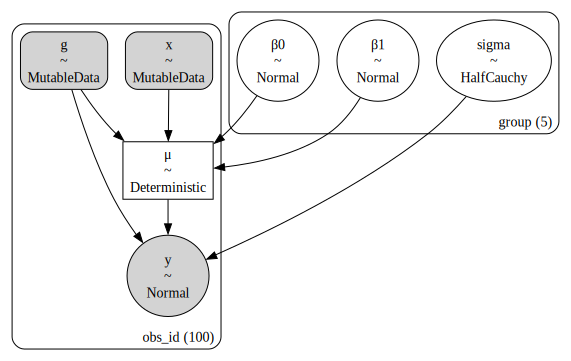

In [20]:
pm.model_to_graphviz(ind_slope_intercept)

In [21]:
with ind_slope_intercept:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time =  0:00:03.046996
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.824680
Transforming variables...
Transformation time =  0:00:00.095270


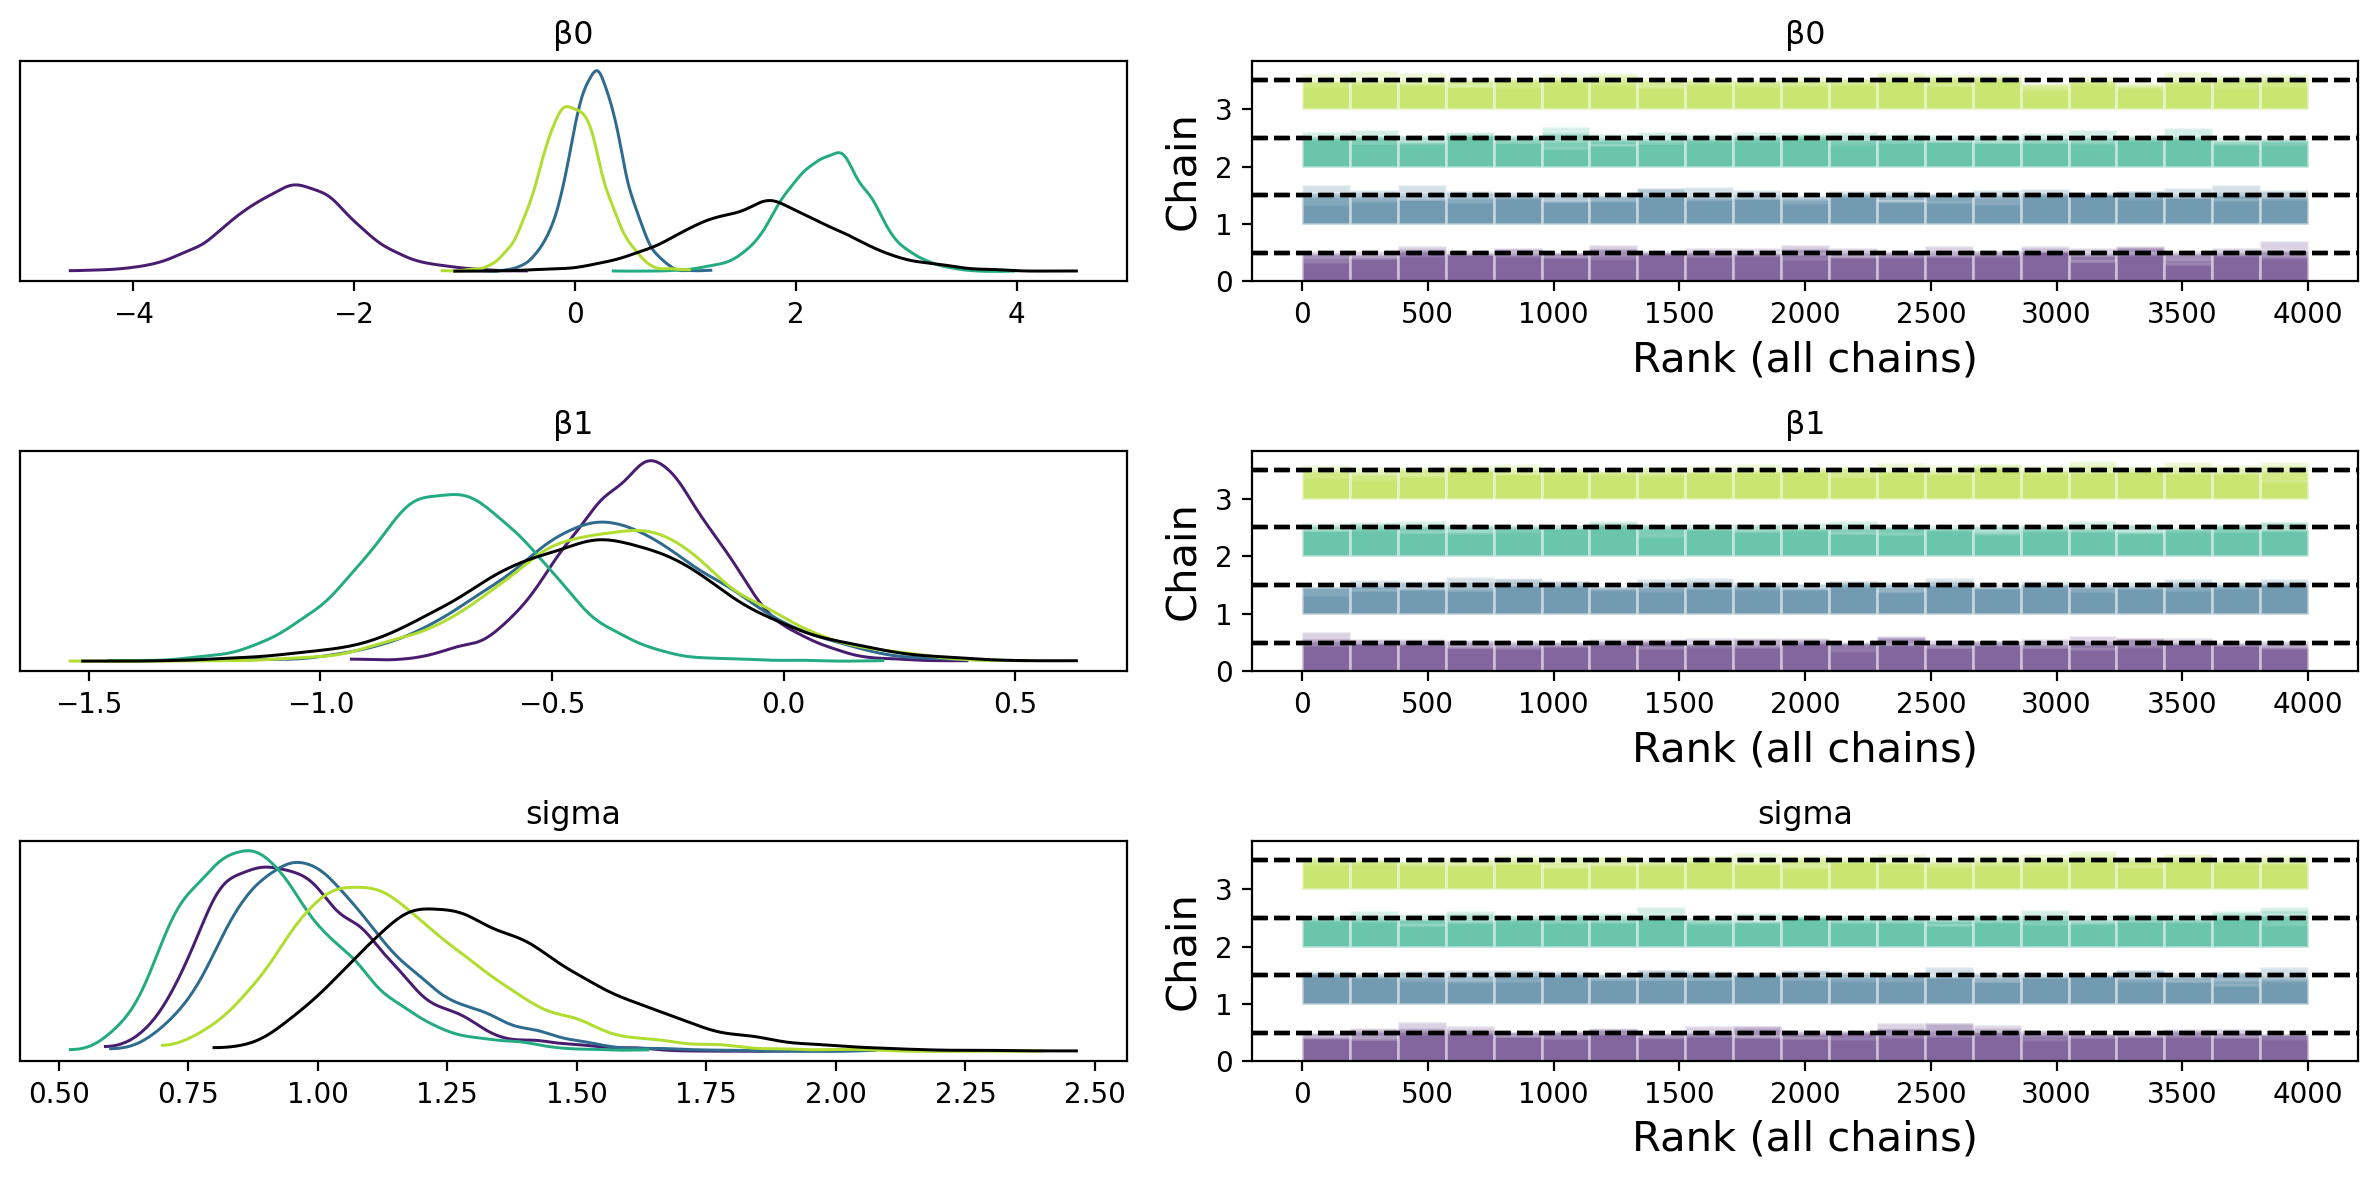

In [22]:
az.plot_trace(
    idata,
    combined=True,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    divergences="bottom",
)
plt.tight_layout()

In [23]:
# Create values of x and g to use for posterior prediction
xi = [
    np.linspace(data.query(f"group_idx=={i}").x.min(), data.query(f"group_idx=={i}").x.max(), 10)
    for i, _ in enumerate(group_list)
]
g = [np.ones(10) * i for i, _ in enumerate(group_list)]
xi, g = np.concatenate(xi), np.concatenate(g)

# Do the posterior prediction
with ind_slope_intercept:
    pm.set_data({"x": xi, "g": g.astype(int)})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["μ", "y"]))

Sampling: [y]


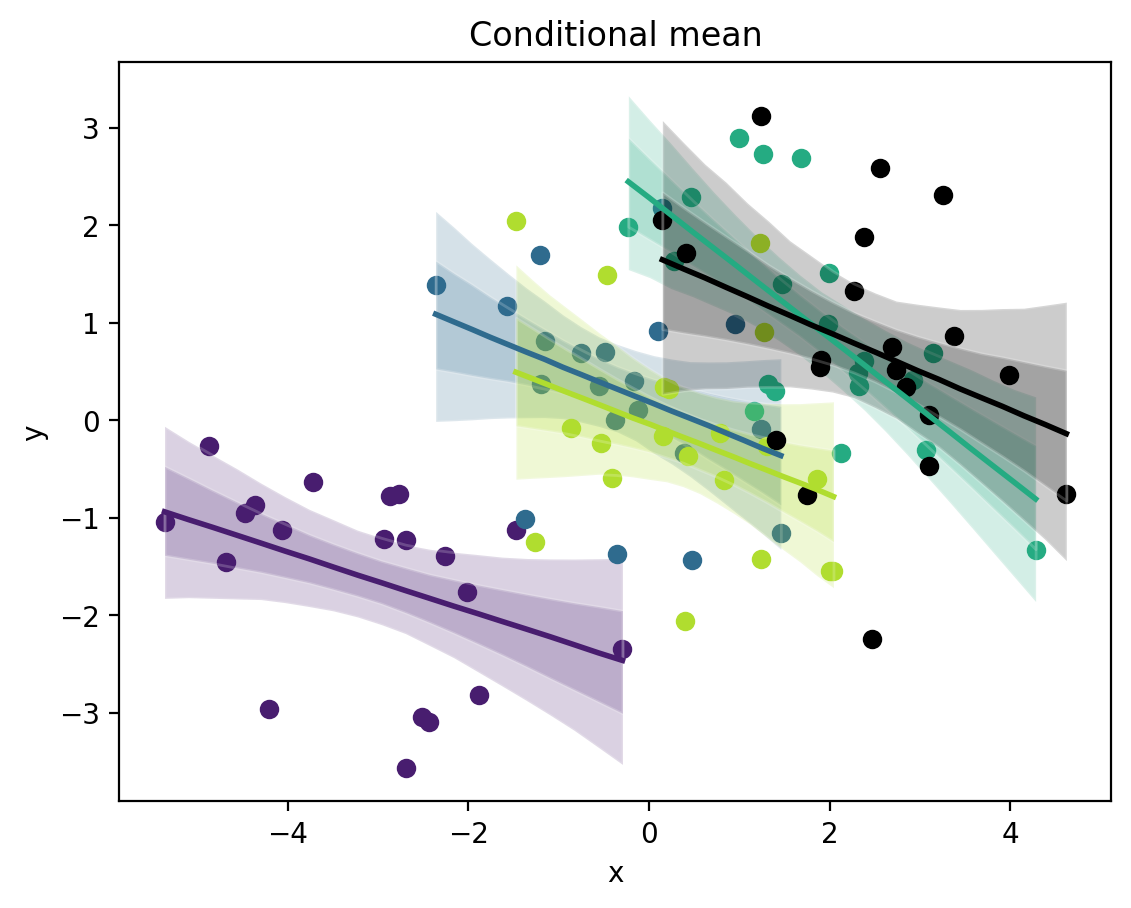

In [24]:
def get_ppy_for_group(group_list, group):
    """Get posterior predictive outcomes for observations from a given group"""
    return idata.posterior_predictive.y.data[:, :, group_list == group]


fig, ax = plt.subplots(1, 1)

# conditional mean plot ---------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax.scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # conditional mean credible intervals
    post = az.extract(idata)
    _xi = xr.DataArray(
        np.linspace(np.min(data.x[data.group_idx == i]), np.max(data.x[data.group_idx == i]), 20),
        dims=["x_plot"],
    )
    y = post.β0.sel(group=groupname) + post.β1.sel(group=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax.fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax.fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    # conditional mean
    ax.plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    # formatting
    ax.set(xlabel="x", ylabel="y", title="Conditional mean")


In [25]:
non_centered = False

with pm.Model(coords=coords) as hierarchical:
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=1)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=2)
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=2)
    sigma_hyperprior = pm.HalfNormal("sigma_hyperprior", sigma=0.5)

    # Define priors
    sigma = pm.HalfNormal("sigma", sigma=sigma_hyperprior, dims="group")

    if non_centered:
        β0_offset = pm.Normal("β0_offset", 0, sigma=1, dims="group")
        β0 = pm.Deterministic("β0", intercept_mu + β0_offset * intercept_sigma, dims="group")
        β1_offset = pm.Normal("β1_offset", 0, sigma=1, dims="group")
        β1 = pm.Deterministic("β1", slope_mu + β1_offset * slope_sigma, dims="group")
    else:
        β0 = pm.Normal("β0", intercept_mu, sigma=intercept_sigma, dims="group")
        β1 = pm.Normal("β1", slope_mu, sigma=slope_sigma, dims="group")

    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

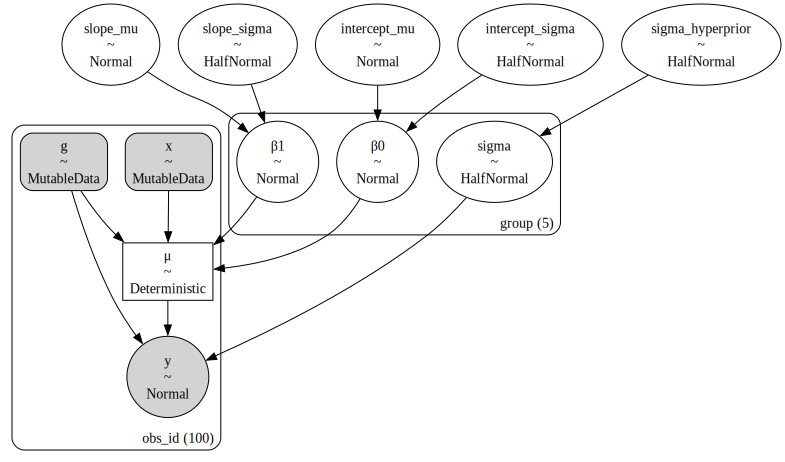

In [26]:
pm.model_to_graphviz(hierarchical)

In [27]:
with hierarchical:
    idata = pm.sampling_jax.sample_numpyro_nuts(tune=5000, target_accept=0.99)

Compiling...


Compilation time =  0:00:01.757603
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:04.572212
Transforming variables...
Transformation time =  0:00:00.025669


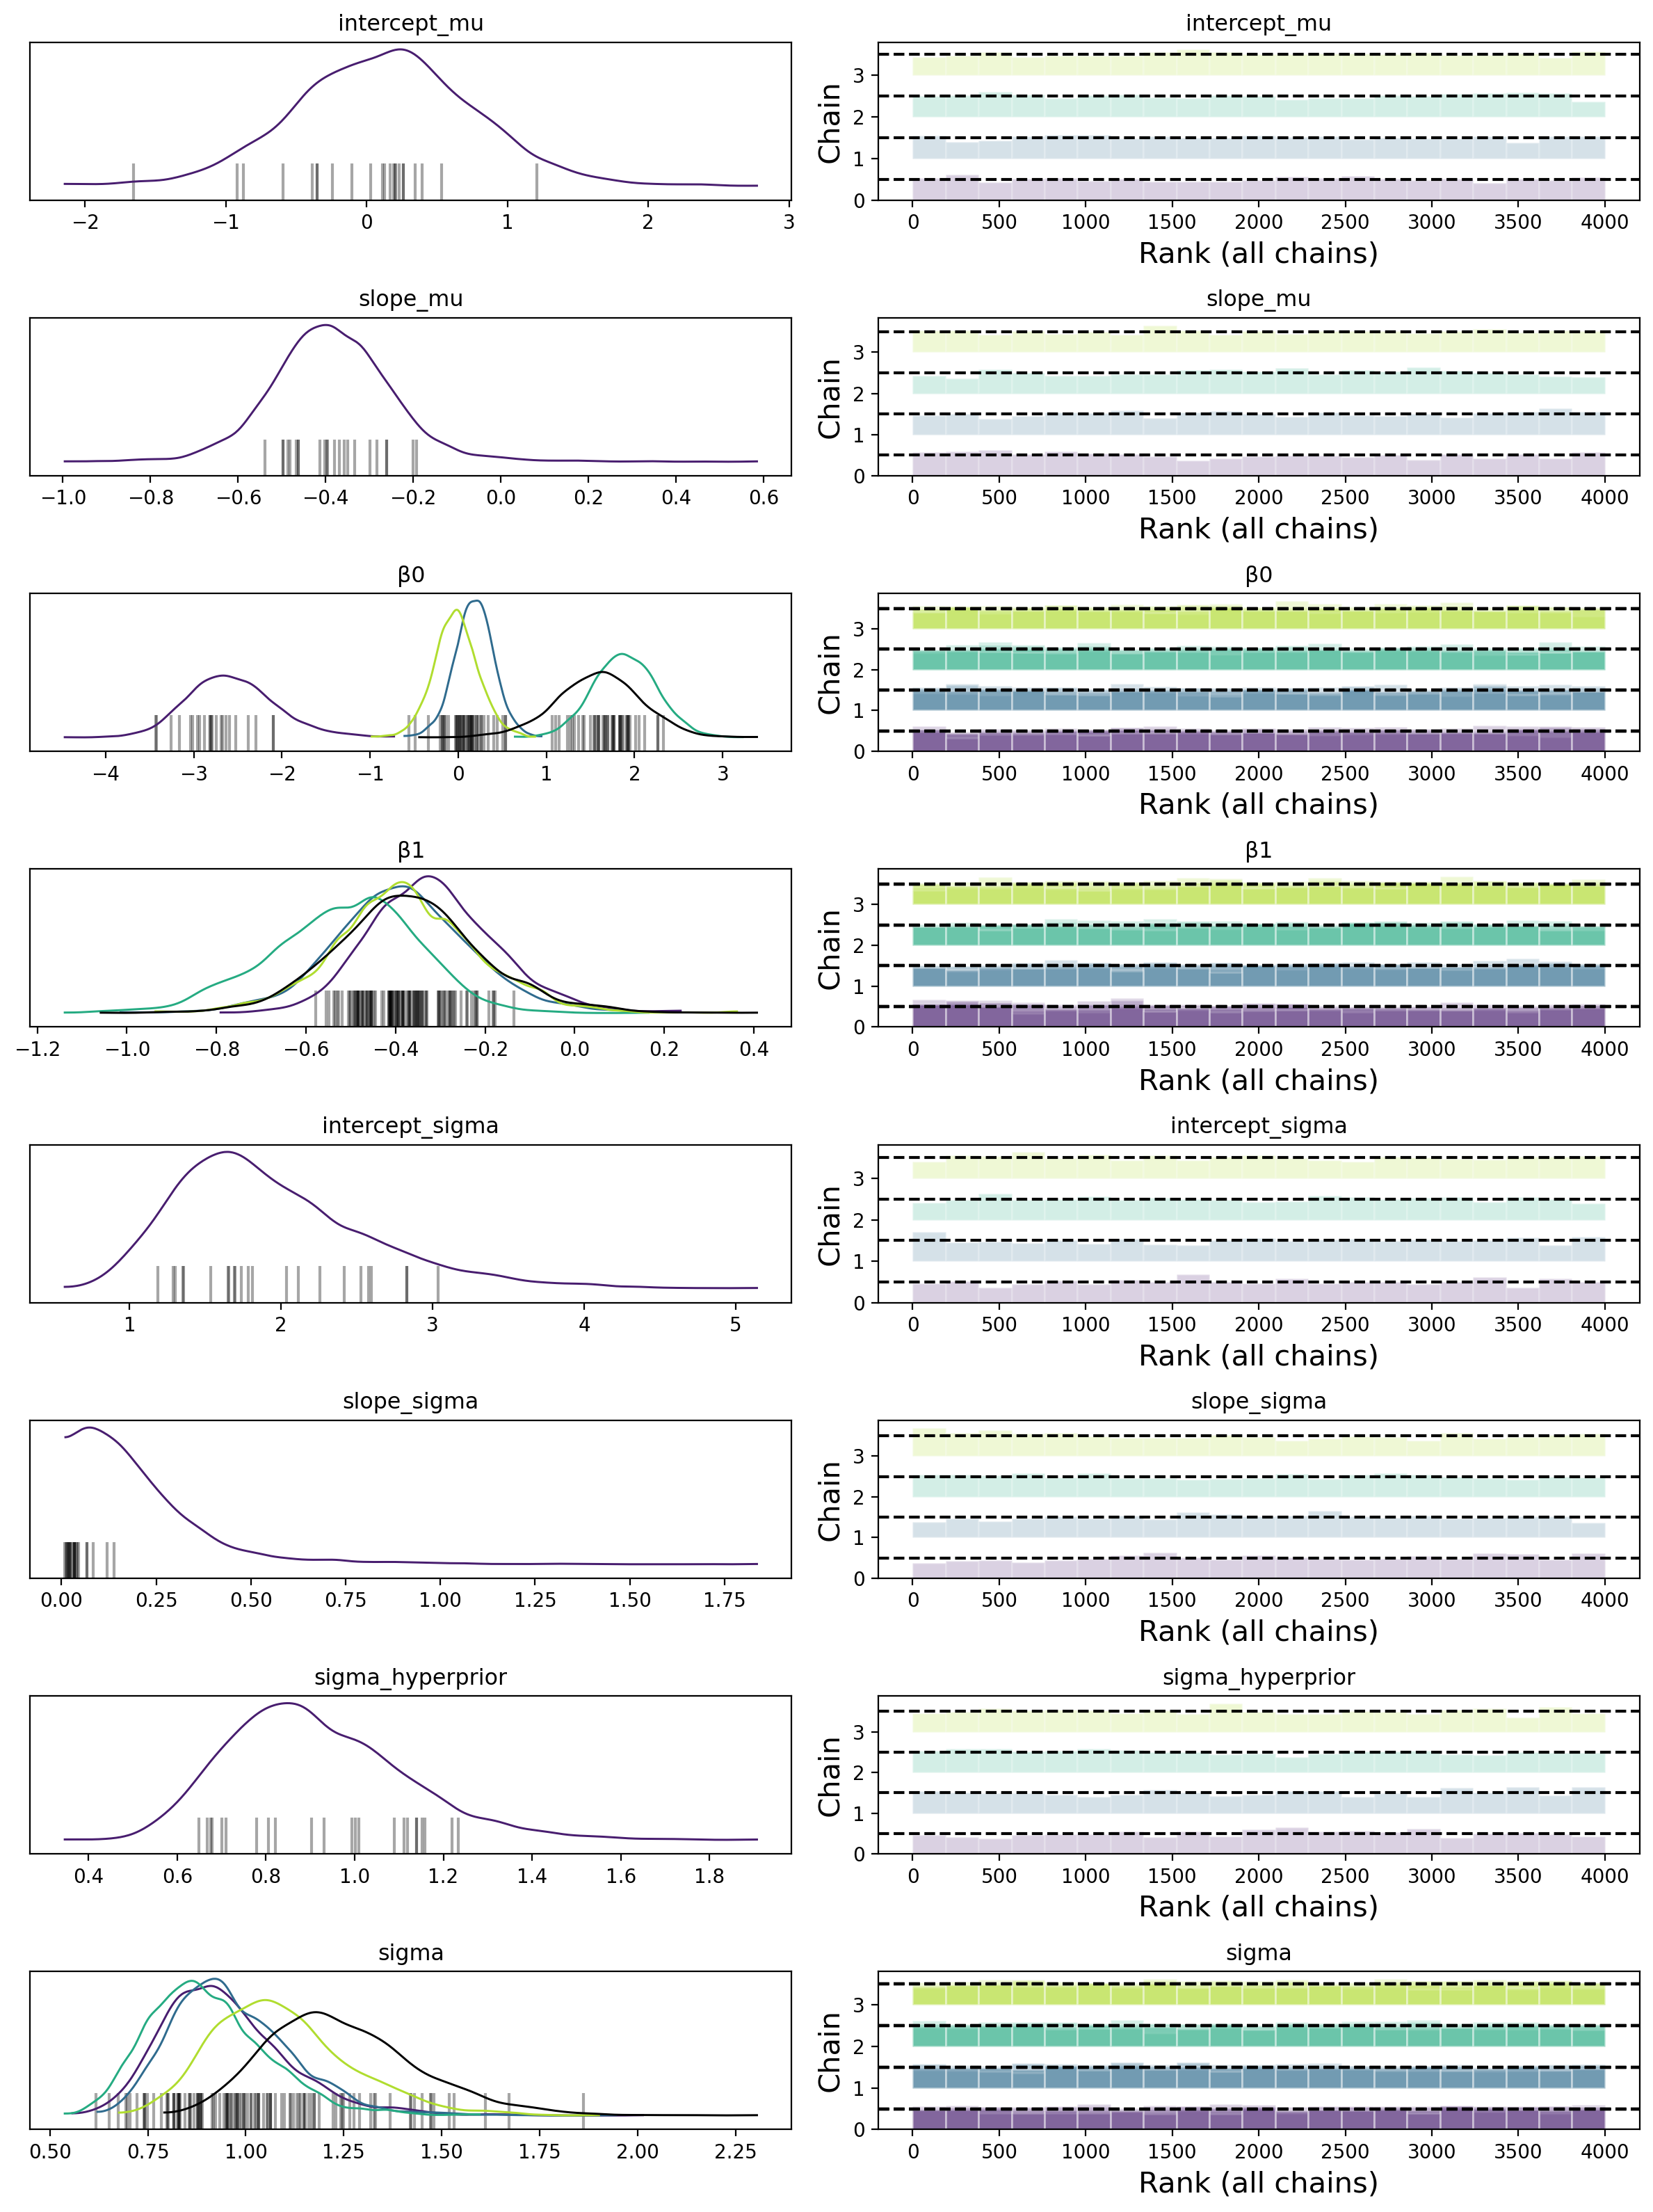

In [28]:
az.plot_trace(
    idata,
    combined=True,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    divergences="bottom",
)
plt.tight_layout()

In [29]:
non_centered = True

with pm.Model(coords=coords) as hierarchical:
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=1)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=2)
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=2)
    sigma_hyperprior = pm.HalfNormal("sigma_hyperprior", sigma=0.5)

    # Define priors
    sigma = pm.HalfNormal("sigma", sigma=sigma_hyperprior, dims="group")

    if non_centered:
        β0_offset = pm.Normal("β0_offset", 0, sigma=1, dims="group")
        β0 = pm.Deterministic("β0", intercept_mu + β0_offset * intercept_sigma, dims="group")
        β1_offset = pm.Normal("β1_offset", 0, sigma=1, dims="group")
        β1 = pm.Deterministic("β1", slope_mu + β1_offset * slope_sigma, dims="group")
    else:
        β0 = pm.Normal("β0", intercept_mu, sigma=intercept_sigma, dims="group")
        β1 = pm.Normal("β1", slope_mu, sigma=slope_sigma, dims="group")

    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

In [30]:
with hierarchical:
    idata = pm.sampling_jax.sample_numpyro_nuts(tune=5000, target_accept=0.99)

Compiling...


Compilation time =  0:00:01.852377
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:04.343403
Transforming variables...
Transformation time =  0:00:00.068851


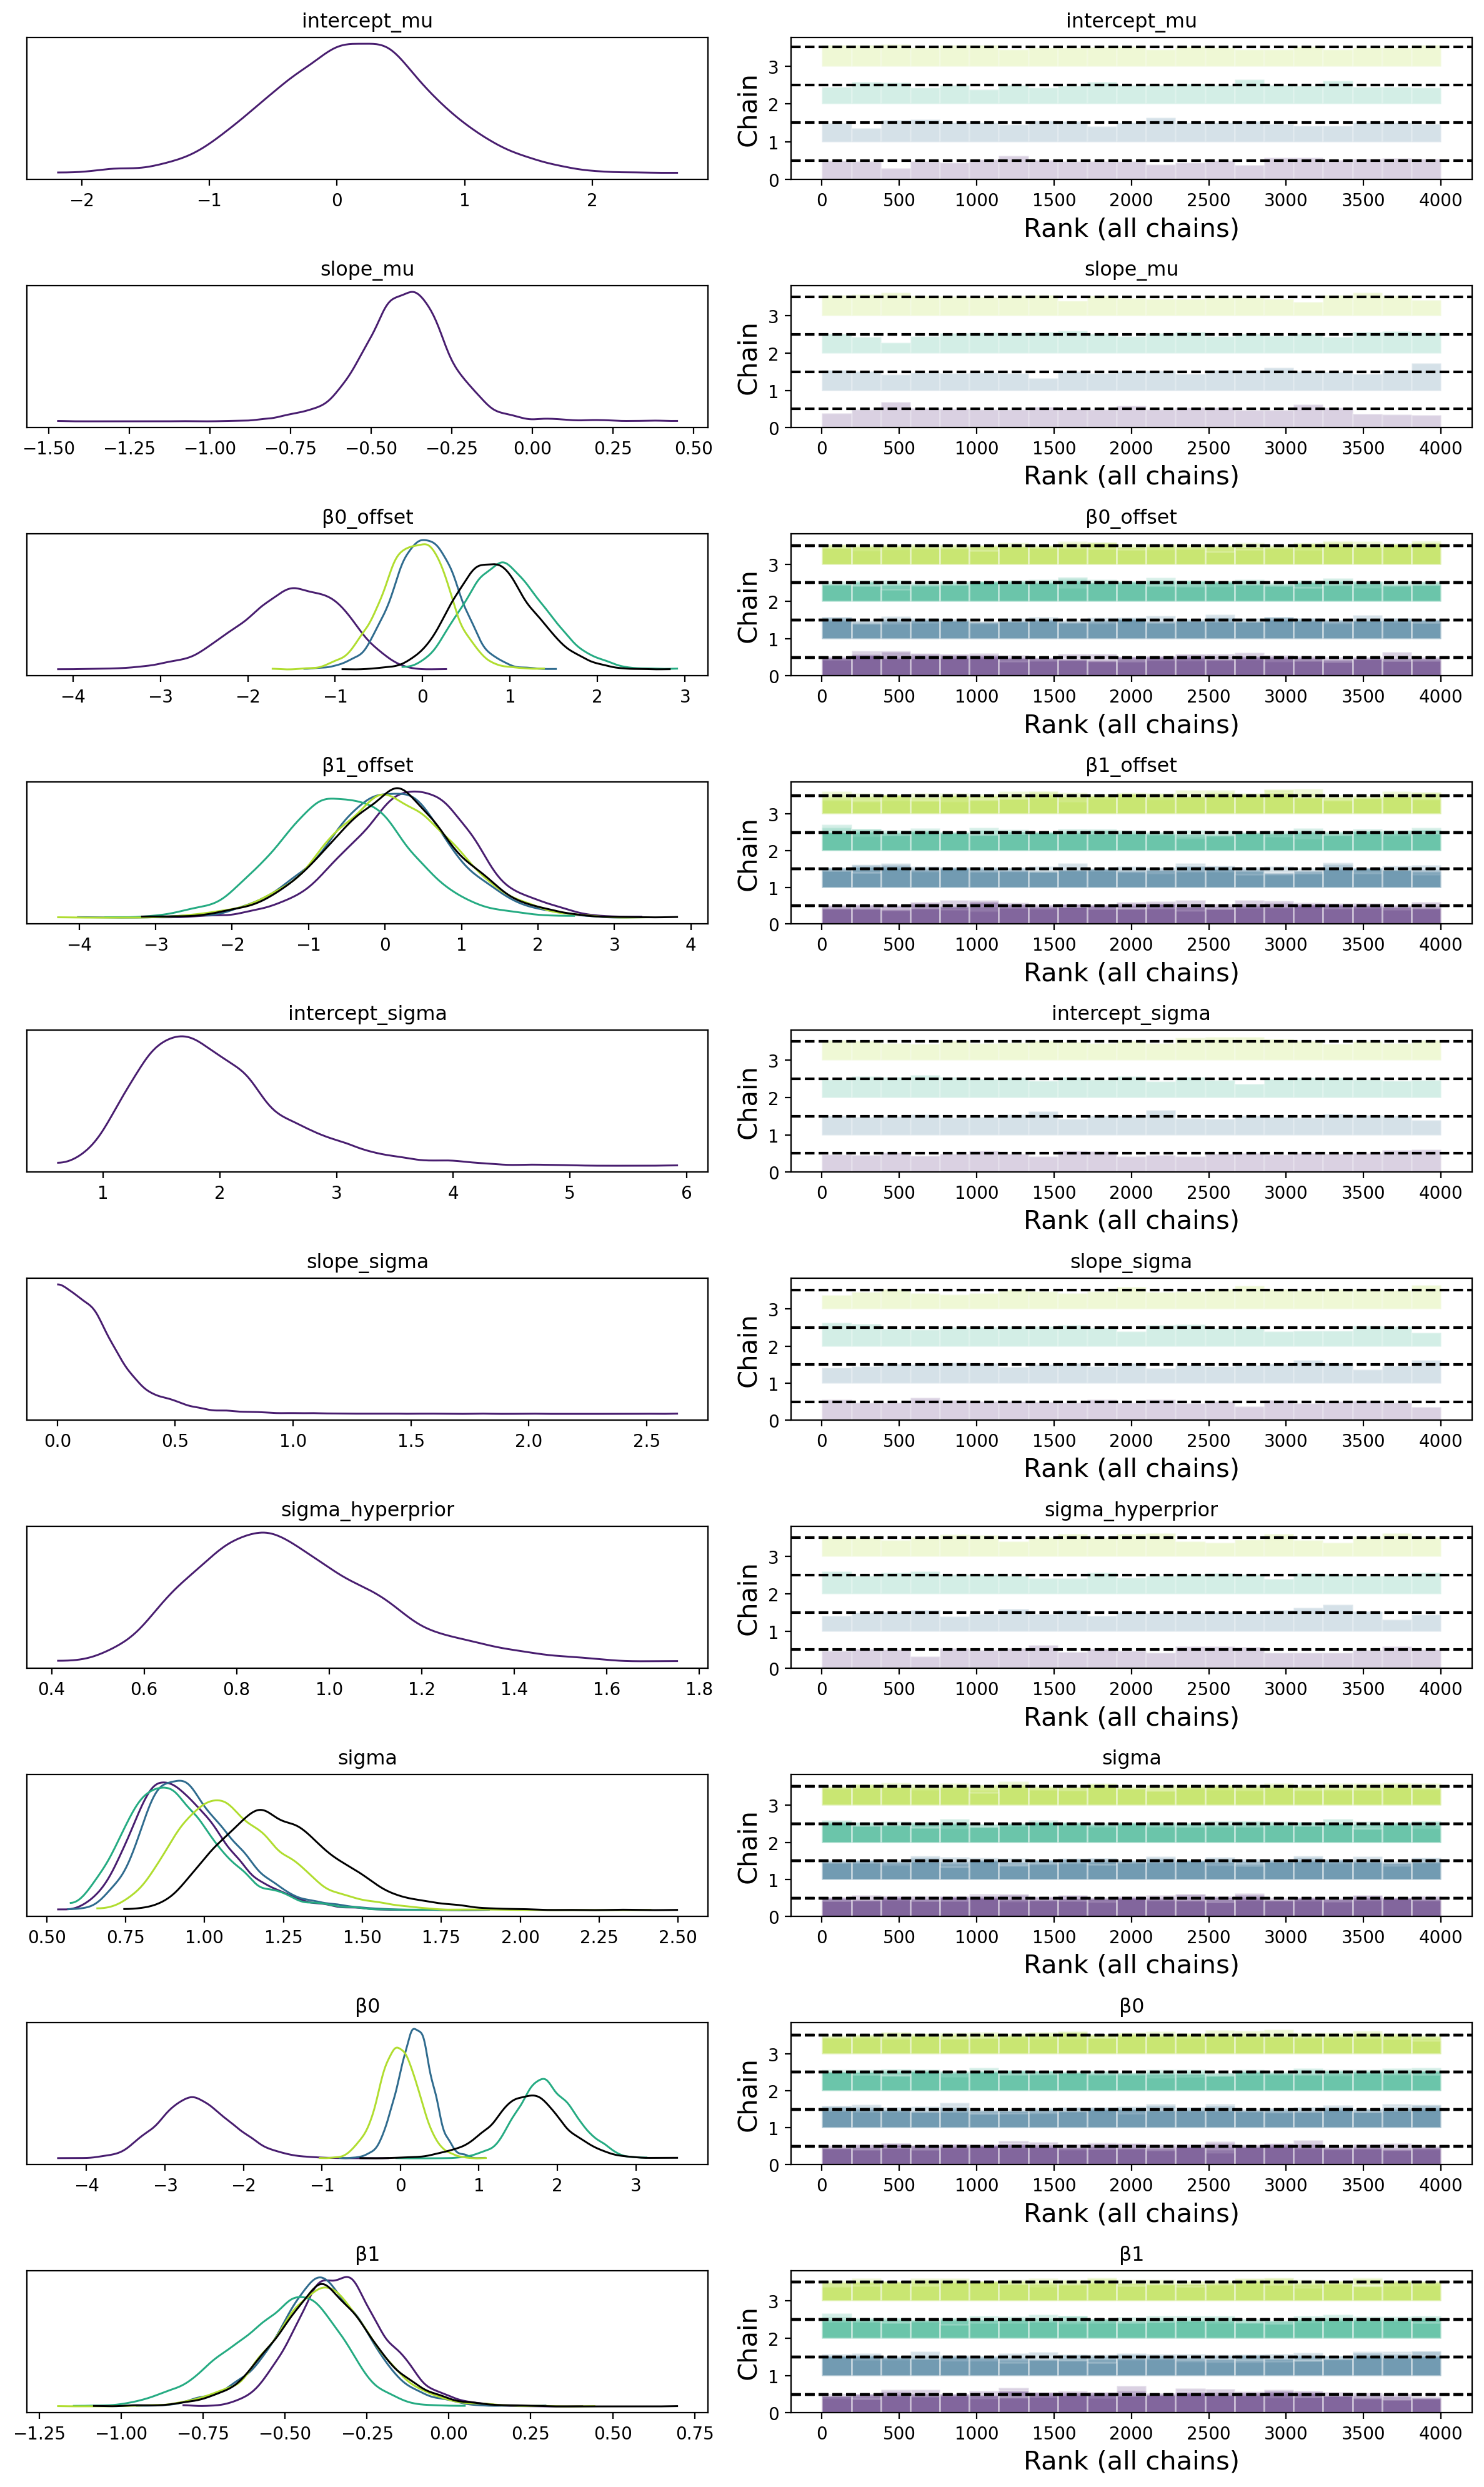

In [31]:
az.plot_trace(
    idata,
    combined=True,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    divergences="bottom",
)
plt.tight_layout()

In [32]:
# Create values of x and g to use for posterior prediction
xi = [
    np.linspace(data.query(f"group_idx=={i}").x.min(), data.query(f"group_idx=={i}").x.max(), 10)
    for i, _ in enumerate(group_list)
]
g = [np.ones(10) * i for i, _ in enumerate(group_list)]
xi, g = np.concatenate(xi), np.concatenate(g)

# Do the posterior prediction
with hierarchical:
    pm.set_data({"x": xi, "g": g.astype(int)})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["μ", "y"]))

Sampling: [y]


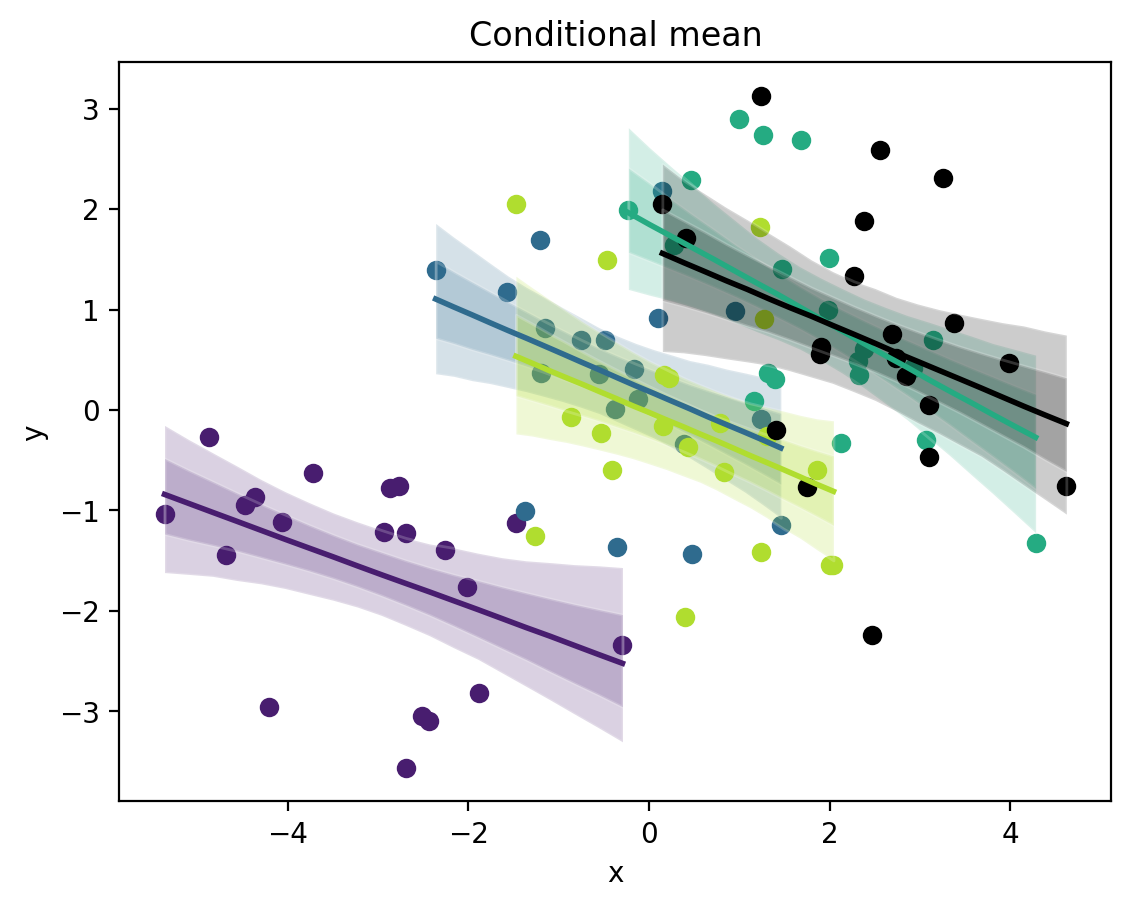

In [33]:
fig, ax = plt.subplots(1, 1)

# conditional mean plot ---------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax.scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # conditional mean credible intervals
    post = az.extract(idata)
    _xi = xr.DataArray(
        np.linspace(np.min(data.x[data.group_idx == i]), np.max(data.x[data.group_idx == i]), 20),
        dims=["x_plot"],
    )
    y = post.β0.sel(group=groupname) + post.β1.sel(group=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax.fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax.fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    # conditional mean
    ax.plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    # formatting
    ax.set(xlabel="x", ylabel="y", title="Conditional mean")


In [34]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

Text(0.5, 1.0, 'Population level slope parameter')

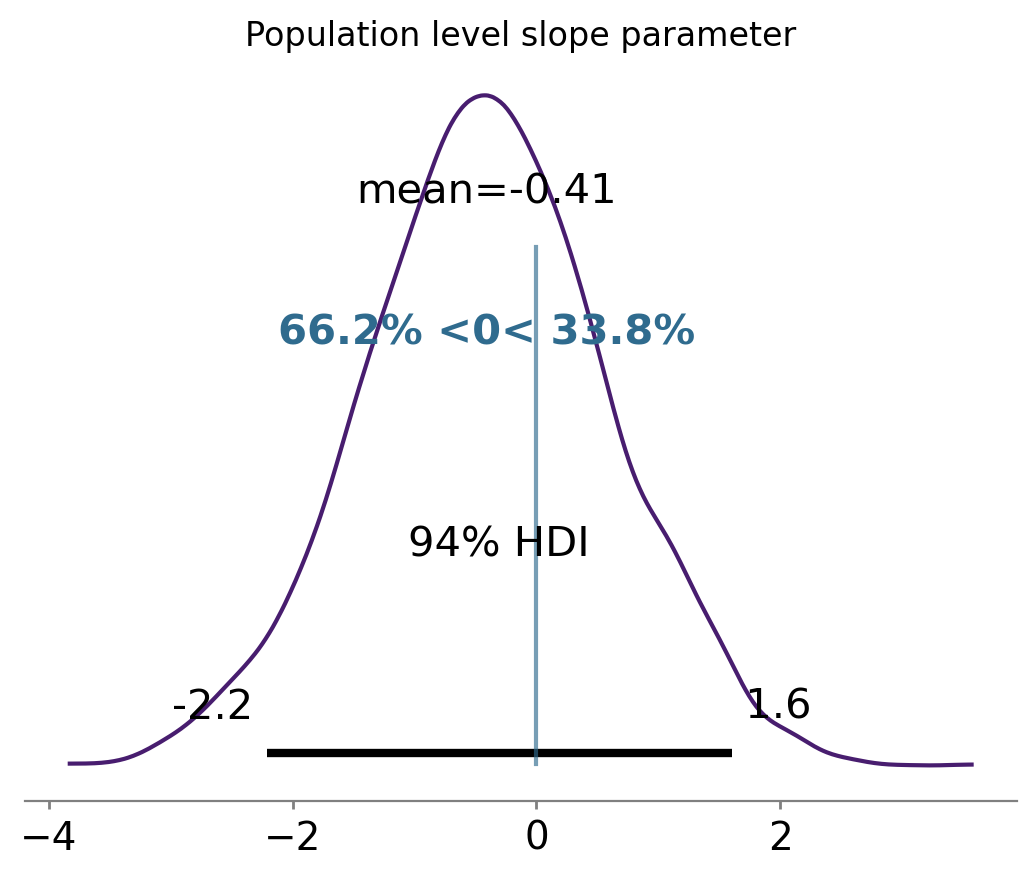

In [35]:
# plot posterior for population level slope
slope = rng.normal(az.extract(idata.posterior, var_names="slope_mu"))
az.plot_posterior(slope, ref_val=0)
plt.title("Population level slope parameter")

In [36]:
%load_ext watermark
%watermark -n -u -v -iv 

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

scipy     : 1.10.1
xarray    : 2023.6.0
numpy     : 1.25.2
arviz     : 0.16.0
pymc      : 5.6.1
pandas    : 2.0.3
seaborn   : 0.12.2
matplotlib: 3.7.2

